In [1]:
%matplotlib inline
import numpy as np

from scipy.stats import linregress
from scipy.stats import gmean
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import rubisco_data

import matplotlib.colors
import seaborn
import pandas as pd

In [2]:
# Load the data from Excel, remove data points that are not comparable.
# raw_kin_df is everything in the file, kin_df is the subset with all relevant kinetic data.
raw_kin_df, kin_df = rubisco_data.load_rubisco_data()

# Want to split data in various ways
# Savir vs. Non-Savir (mostly new) data
savir_pmid = '20142476'
savir_df = raw_kin_df[raw_kin_df.pmid_or_doi == savir_pmid]
nonsavir_df = raw_kin_df[raw_kin_df.pmid_or_doi != savir_pmid]

# Group by RuBisCO form
grouped_form = raw_kin_df.groupby('isoform')

# Markers we use for plotting below.
markers = 'o><^dsphH*'

cnames = ["windows blue", "amber", "greyish brown", "dusty purple", "dusty teal", "dusty red", ]
named_colors = seaborn.xkcd_palette(cnames)

In [3]:
print(raw_kin_df.shape[0], 'total WT RuBisCOs')
print(kin_df.shape[0], 'RuBisCOs with all core kinetic data measured')
print(raw_kin_df.short_ref.unique().size, 'references')

395 total WT RuBisCOs
207 RuBisCOs with all core kinetic data measured
55 references


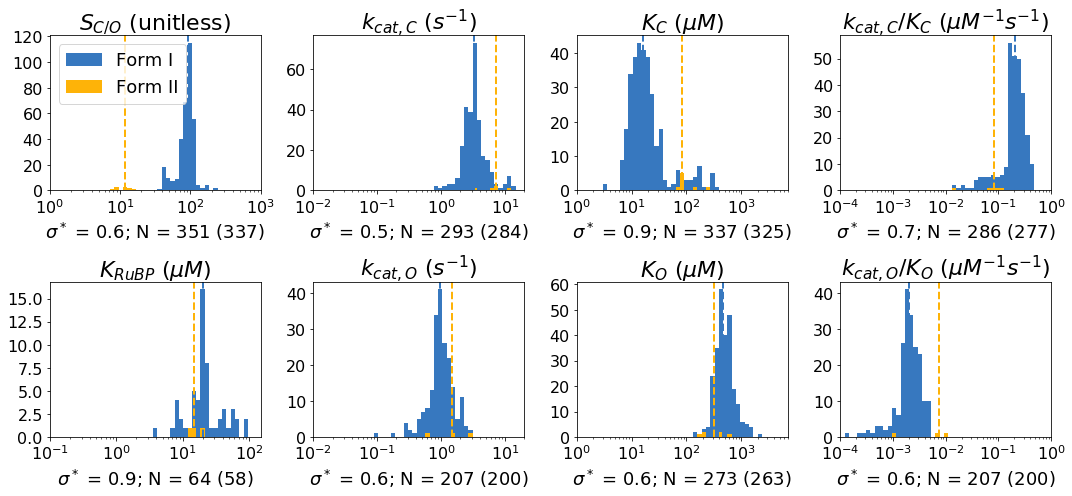

In [6]:
# Description of the data set
figure = plt.figure(figsize=(15,7))

cols = ['S', 'vC', 'KC', 'kon_C', 'KRuBP', 'vO', 'KO', 'kon_O']
titles = {'S': '$S_{C/O}$',
          'vC': '$k_{cat,C}$',
          'KC': '$K_C$',
          'vO': '$k_{cat,O}$',
          'KO': '$K_O$',
          'kon_C': '$k_{cat,C}/K_C$',
          'kon_O': '$k_{cat,O}/K_O$',
          'KRuBP': '$K_{RuBP}$'}
units = {'S': 'unitless',
         'vC': '$s^{-1}$',
         'KC': '$\mu M$',
         'vO': '$s^{-1}$',
         'KO': '$\mu M$',
         'kon_C': '$\mu M^{-1} s^{-1}$',
         'kon_O': '$\mu M^{-1} s^{-1}$',
         'KRuBP': '$\mu M$'}
xlim = {'S': (1, 1e3),
        'vC': (1e-2, 20),
        'vO':(1e-2, 20),
        'KC': (1, 7e3),
        'KO': (1, 7e3),
        'kon_C': (1e-4, 1e0),
        'kon_O': (1e-4, 1e0),
        'KRuBP': (0.1, 1.5e2)}
groups = {'1': 'I', 
          '2': 'II',
          '2_3': 'II/III', 
          '3': 'III'}

nsub = len(cols)
pal = seaborn.color_palette('Set3')

for i, c in enumerate(cols):
    mask = raw_kin_df[c].notnull()
    vals = raw_kin_df[mask][c]
    
    ax = plt.subplot(2, nsub/2.0, i+1)
    plt.xscale('log')
    sigma_star = None

    for j, (group, gdf) in enumerate(raw_kin_df.groupby('isoform')):
        if group == '1':
            sigma_star = np.nanstd(np.log(gdf[c]))
        if group not in ['1', '2']:
            continue
        
        color = named_colors[j]
        label = 'Form %s' % groups[group]
        
        mask = gdf[c].notnull()
        bottom, top = xlim[c]
        bins = np.logspace(np.log10(bottom), np.log10(top), 50)
        plt.hist(gdf[mask][c], bins=bins, label=label, color=color)
        
        median = np.nanmedian(gdf[c])
        plt.axvline(median, color=color, ls='--', lw=2)
        if c == 'S':
            plt.legend(loc=2, frameon=True, fontsize=18)
    
    sigma_star = np.nanstd(np.log(raw_kin_df[c]))
    nvals = raw_kin_df[c].notnull().sum()
    nF1 = raw_kin_df[raw_kin_df.isoform == '1'][c].notnull().sum()
    xlabel = '$\sigma^*$ = %.1f; N = %d (%d)' % (sigma_star, nvals, nF1)

    plt.xlim(*xlim[c])
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel('')
    plt.xlabel(xlabel, fontsize=18, ha='center')
    
    title = '%s (%s)' % (titles[c], units[c])
    plt.title(title, fontsize=22)

plt.subplots_adjust(wspace=0.1)
plt.tight_layout()

plt.savefig('figS3/figS3_histograms.svg')
plt.savefig('figS3/figS3_histograms.png', dpi=400)

plt.show()